In [1]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import torch
from collections import Counter

import random
import os
import re
import json

In [2]:
def get_provo_data(input_data):
    """A function that takes all .json files we created with info for the Provo Corpus
    and merges it into one dictionary"""
    
    #We merge all information in one dictionary
    # Each data point corresponds to all the information relevant to us for a given context in Provo Corpus
    joint_dict = {}
    
    count = 0
    for filename in input_data:
        f = open(filename)
        data = json.load(f)
        f.close()

        for text_id in data.keys():
            if (int(text_id) > 0) & (int(text_id) <= 40):
                for word_num in data[text_id].keys():
                    joint_dict[count] = data[text_id][word_num]
                    joint_dict[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
                
                    count = count + 1

    return joint_dict

In [3]:
os.chdir('/home/eilia/calibration_project/output/data_preprocessing_words')

input_data = ['Paragraphs-1-1.json', 'Paragraphs-2-2.json', 'Paragraphs-3-3_fixed.json',
    'Paragraphs-4-4.json', 'Paragraphs-5-9.json', 'Paragraphs-10-14_fixed.json', 
    'Paragraphs-15-19.json', 'Paragraphs-20-24.json', 'Paragraphs-25-29.json',
    'Paragraphs-30-34.json', 'Paragraphs-35-39_fixed.json', 'Paragraphs-40-44.json']
    # 'Paragraphs-45-47.json', 'Paragraphs-48-50.json', 'Paragraphs-51-53.json',
    #  'Paragraphs-54-55.json']

d = get_provo_data(input_data)


In [4]:
os.chdir('/home/eilia/calibration_project/output/data_preprocessing_words_fine_tuned')

input_data = ['Paragraphs-1-1_fine_tuned.json', 'Paragraphs-2-3_fine_tuned.json', 'Paragraphs-4-7_fine_tuned.json',
        'Paragraphs-8-10_fine_tuned.json', 'Paragraphs-11-14_fine_tuned.json', 'Paragraphs-15-17_fine_tuned.json',
        'Paragraphs-18-20_fine_tuned.json', 'Paragraphs-21-24_fine_tuned.json', 'Paragraphs-25-28_fine_tuned.json',
        'Paragraphs-29-30_fine_tuned.json', 'Paragraphs-31-33_fine_tuned.json', 'Paragraphs-34-36_fine_tuned.json',
         'Paragraphs-37-38_fine_tuned.json', 'Paragraphs-39-40_fine_tuned.json']

d_fine_tuned = get_provo_data(input_data)


In [5]:
human_samples = []
original_corpus_words = []
gpt2_samples = []

for key in d.keys():
    human_samp= [[x['pred']]*int(x['count']) for x in d[key]['human']]
    human_samp = [item for sublist in human_samp for item in sublist]
    original_word = d[key]['original']['pred']
    gpt2_samp = [x for x in d[key]['ancestral_samples']]
    gpt2_samp = [[x['pred']]*int(x['count']) for x in gpt2_samp]
    gpt2_samp = [item.lower() for sublist in gpt2_samp for item in sublist]

    human_samples.append(human_samp)
    gpt2_samples.append(gpt2_samp)
    original_corpus_words.append([original_word])

In [6]:
human_samples_fine_tuned = []
original_corpus_words_fine_tuned = []
gpt2_samples_fine_tuned = []

for key in d_fine_tuned.keys():
    human_samp= [[x['pred']]*int(x['count']) for x in d_fine_tuned[key]['human']]
    human_samp = [item for sublist in human_samp for item in sublist]
    original_word = d_fine_tuned[key]['original']['pred']
    gpt2_samp = [x for x in d_fine_tuned[key]['ancestral_samples']]
    gpt2_samp = [[x['pred']]*int(x['count']) for x in gpt2_samp]
    gpt2_samp = [item.lower() for sublist in gpt2_samp for item in sublist]

    human_samples_fine_tuned.append(human_samp)
    gpt2_samples_fine_tuned.append(gpt2_samp)
    original_corpus_words_fine_tuned.append([original_word])

In [7]:
def sample_oracle_without_replacement_disjoint_groups(words, seed, N = 20):
    """We create two disjoint subsets of the human distribution by sampling without replacement from
    the human distribution (the two disjoing subsets can be comprised by either 10 or 20 samples"""
    #Create a list with all human answers in a flattened out list ['are', 'are', 'they', ..., 'one']
    random.seed(seed)

    #if the length of the list is odd, we remove one element at random to make the list even,
    #since we want the two disjoint subsets to be of equal length
    if (len(words) % 2 == 1): 
        remove_word = random.sample(words, 1)
        words.remove(remove_word[0])

    #We sample the words that will belong in the first subset and create the second subset by removing
    #from the full word list the ones sampled in the first subset
    subset1 = random.sample(words, N)
    if N == 20:
        subset2 = words.copy()
        for item in subset1:
            subset2.remove(item)
    elif N == 10:
        subset_left = words.copy()
        for item in subset1:
            subset_left.remove(item)
        subset2 = random.sample(subset_left, N)
        
    return subset1, subset2

In [9]:
def get_estimator_unbiased(words):
    """For each data point we compute the estimator where the words belong to the unbiased distribution"""
    #Check for failed to generate full-word samples and remove those
    fail = [d for d in words if d == 'Failed to generate word']
    if len(fail) > 0:
        words = [x for x in words if x != 'Failed to generate word']
    
    words = [x for x in words if str(x) != 'nan']
    words = [word.lower() for word in words]
    dict_words = dict(Counter(words))
    support = list(dict_words.keys())
    counts = list(dict_words.values())
    probs = torch.Tensor([x/sum(counts) for x in counts])

    return support, probs

In [10]:
def get_ece_data( assess_words, assess_probs, gold_label_words, gold_label_probs):
    """Considering the estimator distribution, we obtain the word (and its confidence) with the maximum 
    probability. For computing accuracy we consider if this word matches the true label (which we consider for 
    both the cases where they are either the original text word and human majority word"""
    gold_label_probs = gold_label_probs.tolist()
    gold_label_majority_word = gold_label_words[gold_label_probs.index(max(gold_label_probs))]
    
    p_max_word = assess_words[torch.argmax(assess_probs).item()]
    human_maj = (torch.max(assess_probs).item(), int(p_max_word == gold_label_majority_word)) 

    return human_maj

In [11]:
def compute_TVD(probs1, probs2):
    tvd = torch.sum(torch.abs(probs1 - probs2))/2
    return tvd.item()

In [12]:
def compute_entropy(probs):
    #For zero probability values of p in p log p, the contribution to entropy is 0, hence we take only
    #non zero p values into account
    non_zero_probs = probs[probs > 0]
    entropy_probs = - torch.sum(torch.multiply(non_zero_probs, torch.log(non_zero_probs)))

    return entropy_probs.tolist()

In [13]:
def get_tvd_per_instance_for_unbiased_est_dist_and_oracle(model_words, model_probs, oracle_words, oracle_probs):
        """Given the distribution (from the model), we retrieve the human distribution for the same words,
        and then compute TVD for the instance level"""

        #We know that the items of the model distribution and the oracle distribution are not currently aligned
        #Thus, before computing the TVD between them we first need to align the sample space and probabilities between
        #the two distributions
        human_probs = []
        
        list_model_probs = model_probs.tolist()
        list_words = model_words.copy()

        #For the unbiased distributions, the sampled words may not necessarily include all human words. Hence,
        # before creating the human distribution, we add to the model one the ones that are missing with a respective 
        # probability of zero
        list_missing = list(set(oracle_words) - set(list_words)) #set of human words that are not in the model distribution words

        for missing_word in list_missing:
            list_words.append(missing_word)
            list_model_probs.append(0)
        
        #Similarly to the biased dist., we iterate over all words and the human dist. probabilities are either the retrieved
        #probability from the oracle dist. or zero
        for word in list_words:
            try:
                index_word = oracle_words.index(word)
                human_probs.append(oracle_probs[index_word].item())
            except:
                human_probs.append(0)

        tvd = compute_TVD(torch.Tensor(human_probs), torch.Tensor(list_model_probs))
        return(tvd)

In [14]:
def calculate_ECE(conf_acc, ece_bins = 10):
    """Function that given a list of tuples including the confidence of each prediction and if it matches the
    true label computes the ECE. To do that, we split the confidence space (0,1) in bins, separate predictions
    according to the bins, calculate the average confidence per bin and the accuracy per bin and take their weighted
    average."""
    bins = ece_bins
    conf_acc_array = np.array(conf_acc)
    N = conf_acc_array.shape[0]
        
    sum_bin = 0
    for i in np.arange(0, 1, 1/bins):
        #getting all points which belong to the relevant bin - given their 
        bin_contents = conf_acc_array[np.where((conf_acc_array[:,0] >= i) & (conf_acc_array[:,0] < (i + 1/bins)))]
        n_bin = bin_contents[:,0].shape[0]
        if n_bin > 0: #if the bin is non empty
            avg_conf = np.sum(bin_contents[:,0]) / n_bin
            acc = np.sum(bin_contents[:,1]) / n_bin
            sum_bin = sum_bin + abs(avg_conf - acc) * n_bin / N
        
    ece_val = sum_bin
    return(ece_val) 

In [15]:
tvd_gpt2_human_fine_tuned = []
tvd_gpt2_oracle_fine_tuned = []
tvd_oracle2_human_fine_tuned = []
tvd_oracle1_human_fine_tuned = []

ece_gpt2_human_maj_fine_tuned = []
ece_gpt2_corpus_word_fine_tuned = []
ece_gpt2_oracle_maj_fine_tuned = {}

entropy_gpt2_fine_tuned = []
entropy_human_fine_tuned = []
entropy_oracle_fine_tuned = []

for k in range(20):
    ece_gpt2_oracle_maj_fine_tuned[k] = []

for i in range(len(gpt2_samples) - 1):
    human_support, human_probs = get_estimator_unbiased(human_samples_fine_tuned[i])
    gpt2_support, gpt2_probs = get_estimator_unbiased(gpt2_samples_fine_tuned[i])
    corpus_support = original_corpus_words[i]
    corpus_probs = torch.Tensor([1])
    oracle_1, oracle_2 = sample_oracle_without_replacement_disjoint_groups(human_samples_fine_tuned[i], seed =1)
    oracle1_support, oracle1_probs = get_estimator_unbiased(oracle_1)
    oracle2_support, oracle2_probs = get_estimator_unbiased(oracle_2)

    tvd_gpt2_human_fine_tuned.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(gpt2_support, gpt2_probs, human_support, human_probs ))
    tvd_gpt2_oracle_fine_tuned.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(gpt2_support, gpt2_probs, oracle1_support, oracle1_probs ))
    tvd_oracle2_human_fine_tuned.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(oracle2_support, oracle2_probs, human_support, human_probs ))
    tvd_oracle1_human_fine_tuned.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(oracle1_support, oracle1_probs, human_support, human_probs ))

    entropy_gpt2_fine_tuned.append(compute_entropy(gpt2_probs))
    entropy_human_fine_tuned.append(compute_entropy(human_probs))
    entropy_oracle_fine_tuned.append(compute_entropy(oracle1_probs))

    ece_gpt2_human_maj_fine_tuned.append(get_ece_data( gpt2_support, gpt2_probs, human_support, human_probs))
    ece_gpt2_corpus_word_fine_tuned.append(get_ece_data( gpt2_support, gpt2_probs, corpus_support, corpus_probs))
    
    for k in range(20):
        oracle_1, oracle_2 = sample_oracle_without_replacement_disjoint_groups(human_samples[i], k)
        oracle_support, oracle_probs = get_estimator_unbiased(oracle_1)
        ece_gpt2_oracle_maj_fine_tuned[k].append(get_ece_data( gpt2_support, gpt2_probs, oracle_support, oracle_probs))


In [16]:
sum(tvd_gpt2_human_fine_tuned)/len(tvd_gpt2_human_fine_tuned)

0.6557557813015306

In [17]:
tvd_gpt2_human = []
tvd_gpt2_oracle = []
tvd_oracle2_human = []
tvd_oracle1_human = []

ece_gpt2_human_maj = []
ece_gpt2_corpus_word = []
ece_gpt2_oracle_maj = {}

entropy_gpt2 = []
entropy_human = []
entropy_oracle = []

for k in range(20):
    ece_gpt2_oracle_maj[k] = []

for i in range(len(gpt2_samples) - 1):
    human_support, human_probs = get_estimator_unbiased(human_samples[i])
    gpt2_support, gpt2_probs = get_estimator_unbiased(gpt2_samples[i])
    corpus_support = original_corpus_words[i]
    corpus_probs = torch.Tensor([1])
    oracle_1, oracle_2 = sample_oracle_without_replacement_disjoint_groups(human_samples[i], seed =1)
    oracle1_support, oracle1_probs = get_estimator_unbiased(oracle_1)
    oracle2_support, oracle2_probs = get_estimator_unbiased(oracle_2)

    tvd_gpt2_human.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(gpt2_support, gpt2_probs, human_support, human_probs ))
    tvd_gpt2_oracle.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(gpt2_support, gpt2_probs, oracle1_support, oracle1_probs ))
    tvd_oracle2_human.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(oracle2_support, oracle2_probs, human_support, human_probs ))
    tvd_oracle1_human.append(get_tvd_per_instance_for_unbiased_est_dist_and_oracle(oracle1_support, oracle1_probs, human_support, human_probs ))

    entropy_gpt2.append(compute_entropy(gpt2_probs))
    entropy_human.append(compute_entropy(human_probs))
    entropy_oracle.append(compute_entropy(oracle1_probs))

    ece_gpt2_human_maj.append(get_ece_data( gpt2_support, gpt2_probs, human_support, human_probs))
    ece_gpt2_corpus_word.append(get_ece_data( gpt2_support, gpt2_probs, corpus_support, corpus_probs))
    
    for k in range(20):
        oracle_1, oracle_2 = sample_oracle_without_replacement_disjoint_groups(human_samples[i], k)
        oracle_support, oracle_probs = get_estimator_unbiased(oracle_1)
        ece_gpt2_oracle_maj[k].append(get_ece_data( gpt2_support, gpt2_probs, oracle_support, oracle_probs))


In [18]:
gpt2_ft = {}
gpt2_ft['tvd_gpt2_human_fine_tuned'] = tvd_gpt2_human_fine_tuned
gpt2_ft['tvd_gpt2_oracle_fine_tuned'] = tvd_gpt2_oracle_fine_tuned
gpt2_ft['tvd_gpt2_human'] = tvd_gpt2_human


In [24]:
json_string = json.dumps(gpt2_ft)

with open('tvd_gpt2_ft_new.json', 'w') as outfile:
    outfile.write(json_string)

In [19]:
print(calculate_ECE(ece_gpt2_human_maj))
print(calculate_ECE(ece_gpt2_human_maj_fine_tuned))

0.20857453393541647
0.21821014464140612


In [20]:
print(calculate_ECE(ece_gpt2_corpus_word))
calculate_ECE(ece_gpt2_corpus_word_fine_tuned)

0.025521739227427308


0.025976190580668294

In [21]:
ece_subsamples = []
ece_subsamples_fine_tuned = []
for i in range(20):
    ece_subsamples.append(calculate_ECE(ece_gpt2_oracle_maj[i]))
    ece_subsamples_fine_tuned.append(calculate_ECE(ece_gpt2_oracle_maj_fine_tuned[i]))

In [22]:
print(np.std(ece_subsamples))
print(np.std(ece_subsamples_fine_tuned))

0.015823849932579143
0.015301488724448888


In [23]:
print(np.mean(ece_subsamples))
print(np.mean(ece_subsamples_fine_tuned))

0.18908695629566488
0.18646066229651617


In [25]:
print( len(tvd_gpt2_human), len(tvd_gpt2_human_fine_tuned), len(tvd_oracle2_human))

1932 1932 1932


In [26]:
model_column = [['Oracle']*len(tvd_oracle2_human)]
model_column.append(['GPT2']*len(tvd_gpt2_human))
model_column.append(['GPT2 Fine Tuned']*len(tvd_gpt2_human_fine_tuned))

In [27]:
model_column = [item for sublist in model_column for item in sublist]

In [28]:
tvd_column = [tvd_oracle2_human]
tvd_column.append(tvd_gpt2_human)
tvd_column.append(tvd_gpt2_human_fine_tuned)

In [29]:
tvd_column = [item for sublist in tvd_column for item in sublist]

In [30]:
tvd = pd.DataFrame({'Model':model_column, 'TVD':tvd_column})
tvd

,Model,TVD
0,Oracle,0.200000
1,Oracle,0.275000
2,Oracle,0.275000
3,Oracle,0.250000
4,Oracle,0.300000
...,...,...
5791,GPT2 Fine Tuned,0.608526
5792,GPT2 Fine Tuned,0.591105
5793,GPT2 Fine Tuned,0.720000
5794,GPT2 Fine Tuned,0.520000


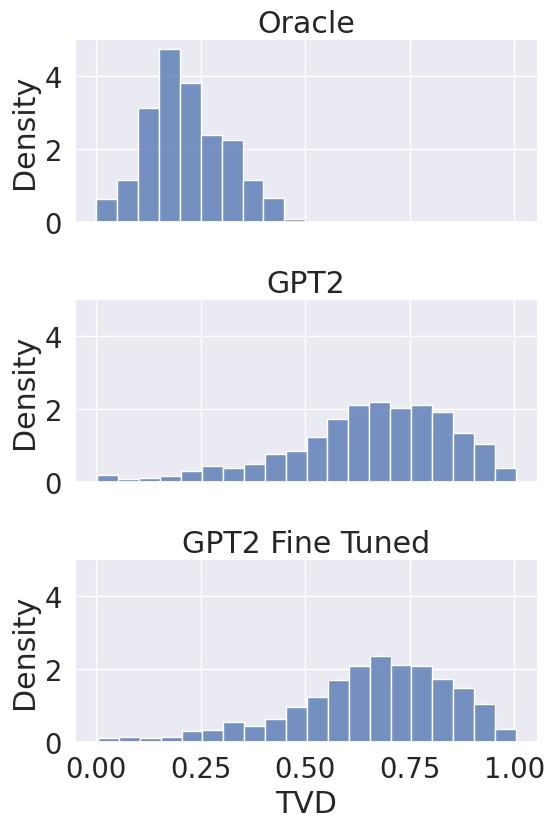

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("RdBu")
sns.set(font_scale=1.8)

#bins='auto', binwidth=None, binrange=None
g = sns.FacetGrid(tvd, row="Model", height=3, aspect=2, sharey=True)
g.set_titles(row_template ='{row_name}')
g.map(sns.histplot, 'TVD', binwidth=0.05, stat = 'density')

g.fig.subplots_adjust(top=0.9) 
#g.fig.suptitle('Histogram of TVDs \n between Model-Human Distributions', fontsize=20)

plt.savefig('TVD_all_models.pdf', format="pdf",bbox_inches='tight')

In [35]:
tvd_centered_gpt2_human_fine_tuned = [tvd_gpt2_human_fine_tuned[i] - tvd_oracle2_human_fine_tuned[i] for i in range(len(tvd_oracle2_human_fine_tuned))]
tvd_centered_gpt2_human = [tvd_gpt2_human[i] - tvd_oracle2_human[i] for i in range(len(tvd_oracle2_human))]
tvd_centered_oracle1_human = [tvd_oracle1_human[i] - tvd_oracle2_human[i] for i in range(len(tvd_oracle2_human))]

In [36]:
model_centered_column = [['Oracle']*len(tvd_centered_oracle1_human)]
model_centered_column.append(['GPT2']*len(tvd_centered_gpt2_human))
model_centered_column.append(['GPT2 Fine-Tuned']*len(tvd_centered_gpt2_human_fine_tuned))

model_centered_column = [item for sublist in model_centered_column for item in sublist]

In [37]:
tvd_centered_column = [tvd_centered_oracle1_human]
tvd_centered_column.append(tvd_centered_gpt2_human)
tvd_centered_column.append(tvd_centered_gpt2_human_fine_tuned)

tvd_centered_column = [item for sublist in tvd_centered_column for item in sublist]

In [38]:
tvd = pd.DataFrame({'Model':model_centered_column, 'TVD Difference':tvd_centered_column})
tvd

,Model,TVD Difference
0,Oracle,-2.980232e-08
1,Oracle,0.000000e+00
2,Oracle,2.980232e-08
3,Oracle,0.000000e+00
4,Oracle,2.980232e-08
...,...,...
5791,GPT2 Fine-Tuned,4.272397e-01
5792,GPT2 Fine-Tuned,4.273626e-01
5793,GPT2 Fine-Tuned,6.410527e-01
5794,GPT2 Fine-Tuned,3.679532e-01


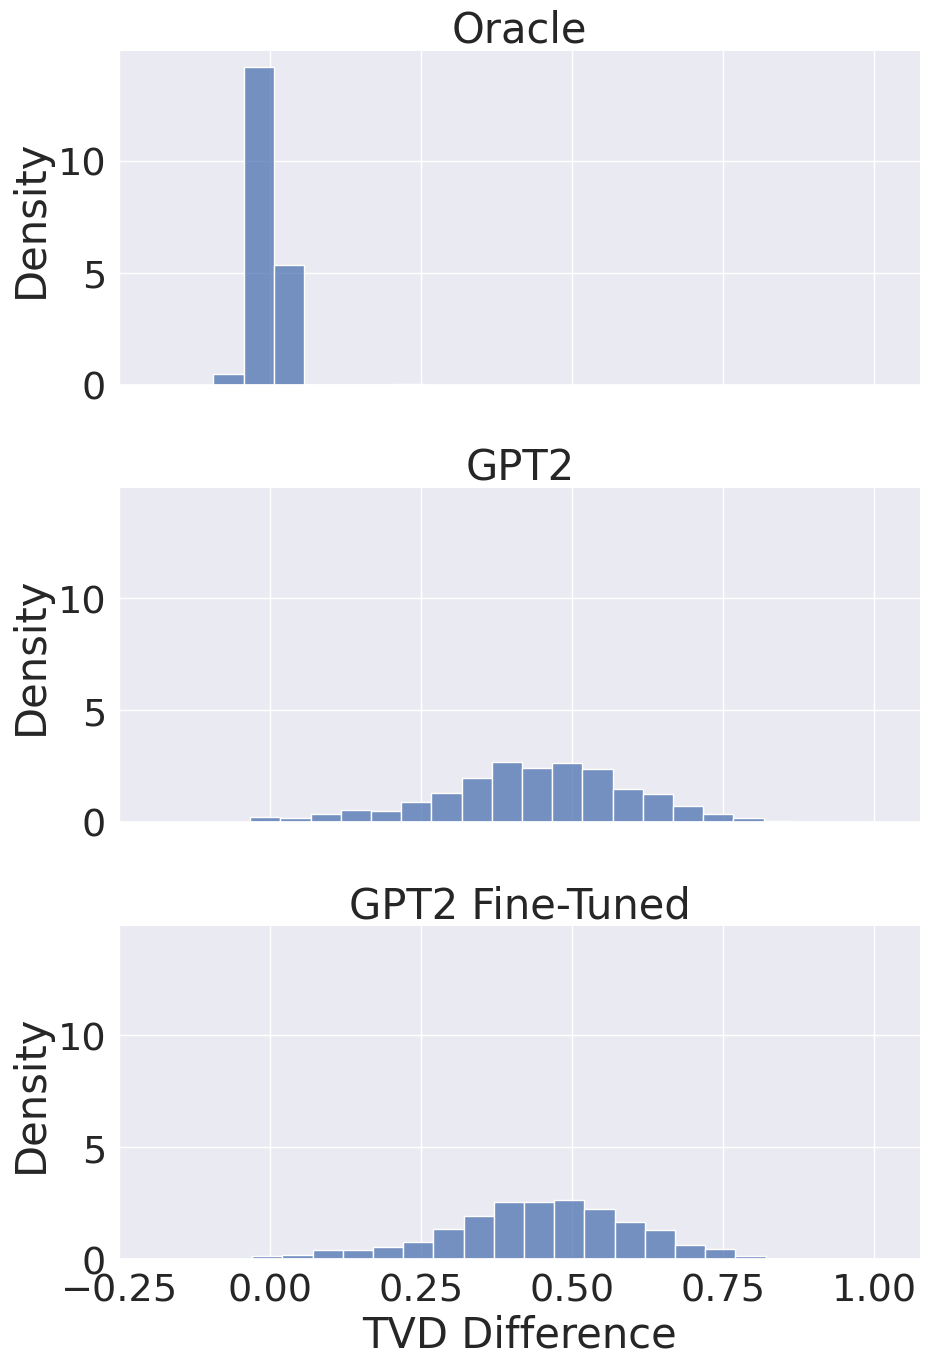

In [39]:
sns.set_palette("RdBu")
sns.set(font_scale=2.5)

g = sns.FacetGrid(tvd, row="Model", height=5, aspect=2, sharey=True)
g.map(sns.histplot, 'TVD Difference', binwidth=0.05, stat = 'density')
g.set_titles(row_template ='{row_name}')

g.fig.subplots_adjust(top=0.9) 
g.set(xticks=np.arange(-0.25,1.25,0.25))
plt.savefig('TVD_centered_all_models.pdf', format="pdf",bbox_inches='tight')

In [40]:
tvd_change = [tvd_gpt2_human_fine_tuned[i] - tvd_gpt2_human[i] for i in range(len(tvd_gpt2_human))]

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 7.000e+00, 2.000e+00, 1.200e+01, 3.450e+02, 1.389e+03,
        1.480e+02, 1.100e+01, 4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 5.000e+00]),
 array([-0.87799997, -0.8000947 , -0.72218944, -0.64428417, -0.56637891,
        -0.48847364, -0.41056838, -0.33266311, -0.25475785, -0.17685258,
        -0.09894732, -0.02104206,  0.05686321,  0.13476847,  0.21267374,
         0.290579  ,  0.36848427,  0.44638953,  0.5242948 ,  0.60220006,
         0.68010533]),
 <BarContainer object of 20 artists>)

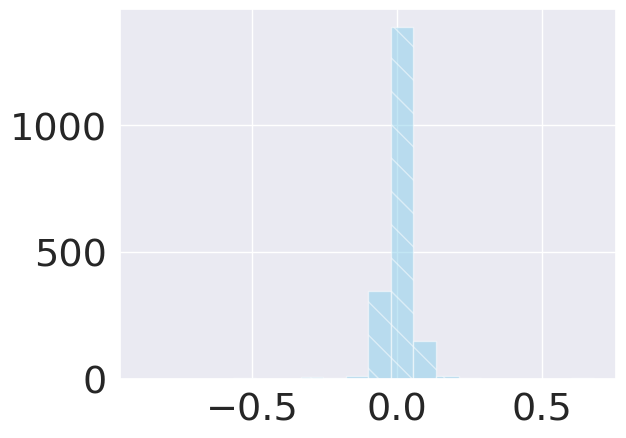

In [41]:
plt.hist(tvd_change, bins=20, alpha=0.5, label='Fine-tuned model', color='Skyblue', hatch='\\')